In [1]:
import pandas as pd
import mdtraj as md
import numpy as np
from numpy.random import seed
from numpy.random import shuffle
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from __future__ import print_function
import seaborn as sns
from matplotlib.ticker import NullFormatter, MaxNLocator
from pandas.plotting import scatter_matrix
import matplotlib.ticker as ticker
import plotly.graph_objects as go
import scipy as sp
from itertools import chain
import matplotlib as mpl
from matplotlib.lines import Line2D
from scipy import spatial
from scipy.spatial import ConvexHull
from scipy.optimize import curve_fit
import scipy.stats as stats
import statsmodels.stats.weightstats
from matplotlib import path
import matplotlib
from scipy.stats import probplot,shapiro, sem
import statsmodels.api as sm
from scipy.interpolate import make_interp_spline
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

from scipy import stats
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,r2_score, mean_squared_error
from sklearn.metrics import RocCurveDisplay, roc_auc_score
from sklearn.linear_model import RidgeCV
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay,classification_report
from sklearn.svm import SVC, SVR
from sklearn.preprocessing import LabelEncoder, label_binarize, StandardScaler

from matplotlib import cm
from numpy import linspace
import umap.umap_ as umap
#import pylab
import os
#import PIL
#from scipy.ndimage import gaussian_filter, uniform_filter1d

# Some Functions

In [2]:
def RSA_based_fC(protein_var,protein_name,poly_id,
                       GW_moment_var,every_ith_snap,GW_every_ith_snap,radius_):
    x_total=[]
    y_total=[]
    if poly_id=='protein':
        protein_label=protein_name
        temp_protein=protein_var.copy()
        x_total.append(temp_protein.RSA.values)
        y_total.append(temp_protein.ratio.values)
        x_total=list(chain.from_iterable(x_total))
        y_total=list(chain.from_iterable(y_total))
        poly_var=protein_var.copy()
        protein_pro=poly_var[['ratio','RSA']].iloc[:every_ith_snap,:].copy()
        protein_pro['polymer_id']=np.repeat(protein_label,protein_pro.shape[0])
        del x_total, y_total, temp_protein
    else:
        return print('ERROR')

    GW_po=GW_moment_var[['ratio','RSA']][::GW_every_ith_snap].copy()
    GW_po['polymer_id']=np.repeat('GW',GW_po.shape[0])
    
    #calculate mean and stdev values (must keep same mean and stdev values)
    upto_snapshots=1000000
    GW_mean_ratio=np.mean(GW_po['ratio'].values[0:(upto_snapshots+1)])
    GW_std_ratio=np.std(GW_po['ratio'].values[0:(upto_snapshots+1)])
    GW_mean_RSA=np.mean(GW_po['RSA'].values[0:(upto_snapshots+1)])
    GW_std_RSA=np.std(GW_po['RSA'].values[0:(upto_snapshots+1)])
        
    combined_pro_po=pd.concat([GW_po,protein_pro],axis=0,ignore_index=True)
    combined_pro_po['stdd_ratio']=(combined_pro_po['ratio'].values-GW_mean_ratio)/(GW_std_ratio)
    combined_pro_po['stdd_RSA']=(combined_pro_po['RSA'].values-GW_mean_RSA)/(GW_std_RSA)
    po_x=combined_pro_po[combined_pro_po.polymer_id=='GW']['stdd_RSA'].values
    po_y=combined_pro_po[combined_pro_po.polymer_id=='GW']['stdd_ratio'].values
    pro_x=combined_pro_po[combined_pro_po.polymer_id==protein_label]['stdd_RSA'].values
    pro_y=combined_pro_po[combined_pro_po.polymer_id==protein_label]['stdd_ratio'].values
    
    GW_points=np.c_[po_x, po_y]
    protein_points=np.c_[pro_x, pro_y]    
    tree_GW=spatial.cKDTree(GW_points)
    tree_protein=spatial.cKDTree(protein_points)

    GW_not_in_range=[]
    j=0
    for point in GW_points:

        if not tree_protein.query_ball_point(point,radius_):
            GW_not_in_range.append(point)
        j+=1
        if j%100000==0:
            print(f'{j} GW snapshots completed')
                
    fC_by_distance=(GW_points.shape[0]-len(GW_not_in_range))/(GW_points.shape[0])
    return fC_by_distance    


In [3]:
def RSA_Rs_protein_3dplot_against_GW(protein_var,protein_label,second_obj,provided_color):
    
    x_variable= 'RSA'
    y_variable=r'$R_s$'
    global fC_value, grid_protein, grid_GW

    testeq_GW= pd.read_csv('../segmented_chain_project/reference_GW_chainlen_100_for_RSA.csv')
    
    plt.rcParams["font.weight"] = "regular"
    plt.rcParams["axes.labelweight"] = "regular"
    
    
    x_polmodel_GW=[]
    y_polmodel_GW=[]
    x_total=[]
    y_total=[]

    scatter_markers=['d','x',4,'o','v','^','1','8','s','p','P','*','X','D',9]


    x_polmodel_GW.append(testeq_GW['RSA'].values)
    y_polmodel_GW.append(testeq_GW['ratio'].values)

    if second_obj=='protein':        
        temp_protein =  protein_var.copy()

        x_total.append(temp_protein.RSA.values)
        y_total.append(temp_protein.ratio.values)

        fC_value=RSA_based_fC(temp_protein,
                       protein_label,
                       second_obj,testeq_GW,
                       temp_protein.shape[0],
                       1,0.1)            
        del temp_protein
    else:
        print('ERROR. FIX ERROR')

    x_total=list(chain.from_iterable(x_total))
    y_total=list(chain.from_iterable(y_total))
    x_polmodel_GW=list(chain.from_iterable(x_polmodel_GW))
    y_polmodel_GW=list(chain.from_iterable(y_polmodel_GW))

    # Set up default x and y limits
    max_x_val=1
    max_y_val=30
    xlims = [0,max_x_val]
    ylims = [0,max_y_val]
    if testeq_GW['RSA'].max()>max_x_val or testeq_GW['RSA'].min()<0:
        return print('ERROR')
    elif max(x_total)>max_x_val or min(x_total)<0:
        return print('ERROR')        
    elif testeq_GW['ratio'].max()>max_y_val or testeq_GW['ratio'].min()<0:
        return print('ERROR')
    elif max(y_total)>max_y_val or min(y_total)<0:
        return print('ERROR')        

    # Set up your x and y labels
    xlabel = x_variable
    ylabel = y_variable

    # Define the locations for the axes

    left, width = 0.12, 0.55
    bottom, height = 0.12, 0.55
    bottom_h = left_h = left+width
    rect_temperature = [left, bottom, width, height] # dimensions of temp plot
    rect_histx = [left, bottom_h, width, 0.25] # dimensions of x-histogram
    rect_histy = [left_h, bottom, 0.25, height] # dimensions of y-histogram


    # Set up the size of the figure
    fig = plt.figure(1, figsize=(5.2,5))

    # Make the three plots
    axTemperature = plt.axes(rect_temperature) # temperature plot
    axHistx = plt.axes(rect_histx) # x histogram
    axHisty = plt.axes(rect_histy) # y histogram


    axHistx.axes.get_xaxis().set_visible(False)
    axHisty.axes.get_yaxis().set_visible(False)


    # Find the min/max of the data
    xmin = min(xlims)
    xmax = max(xlims)
    ymin = min(ylims)
    ymax = max(ylims)

    # Remove the inner axes numbers of the histograms
    nullfmt = NullFormatter()
    #
    # Define the number of bins
    nxbins = 100
    nybins = 50
    nbins = nxbins+nybins

    xbins = linspace(start = xmin, stop = xmax, num = nxbins)
    ybins = linspace(start = ymin, stop = ymax, num = nybins)
    xcenter = (xbins[0:-1]+xbins[1:])/2.0
    ycenter = (ybins[0:-1]+ybins[1:])/2.0
    aspectratio = (1.0*(xmax - 0))/(1.38*ymax - 0)


    X = xcenter
    Y = ycenter

    axTemperature.scatter(x_polmodel_GW,y_polmodel_GW,
                      marker=scatter_markers[3],s=1,alpha=0.6,color='black',
                       label='GW')
    
    axTemperature.scatter(x_total,
               y_total,
               marker=scatter_markers[0],s=1,alpha=0.6,color=provided_color,
                                      label=protein_label)                



    #Plot the axes labels
    axTemperature.set_xlabel(xlabel,fontsize=12,labelpad = 1)
    axTemperature.set_ylabel(ylabel,fontsize=12, labelpad = 1)

    #Set up the plot limits
    axTemperature.set_xlim(xlims)
    axTemperature.set_ylim(ylims)

    #Set up the histogram bins
    xbins = np.arange(xmin, xmax, (xmax-xmin)/nbins)
    ybins = np.arange(ymin, ymax, (ymax-ymin)/nbins)


    axHistx.hist(x_polmodel_GW, bins=xbins, color = 'black',histtype='step',
                linewidth = 0.7,density=True)
    axHistx.hist(x_total, bins=xbins, color = provided_color,histtype='step',
                label=protein_label,linewidth = 0.7,density=True)

    axHisty.hist(y_polmodel_GW, bins=np.arange(min(y_total),max(y_total),1), color = 'black',orientation='horizontal',histtype='step',
                linewidth = 0.7,density=True)

    axHisty.hist(y_total, bins=ybins, color = provided_color,orientation='horizontal',histtype='step',
                label=protein_label,linewidth = 0.7,density=True)    
    
    #original_n_divisions=100
    step_x=0.02#(min(x_polmodel_GW)-max(x_polmodel_GW))/original_n_divisions
    step_y=0.6#(min(y_polmodel_GW)-max(y_polmodel_GW))/original_n_divisions
    max_value_x=max(xlims)
    n_divisions_x=round((max_value_x-min(xlims))/step_x)
    
    max_value_y=max(ylims)
    n_divisions_y=round((max_value_y-min(ylims))/step_y)
    #gridx = np.linspace(min(x_polmodel_GW), max(x_polmodel_GW), n_divisions_x)
    gridx = np.linspace(min(xlims), max(xlims), n_divisions_x)
    #gridy = np.linspace(min(y_polmodel_GW), max(y_polmodel_GW), n_divisions_y)
    gridy = np.linspace(min(ylims), max(ylims), n_divisions_y)
    
    grid_protein, _, _ = np.histogram2d(x_total, y_total, bins=[gridx, gridy])
    grid_GW, _, _ = np.histogram2d(x_polmodel_GW, y_polmodel_GW, bins=[gridx, gridy])

    axTemperature.text(0.7,0.8,
                       '$f_C$= '+format(fC_value,'0.3f'),
                      transform=axTemperature.transAxes,fontsize=8)
    axTemperature.text(0.7,0.74,
                       '$f_A$= '+format(np.count_nonzero(grid_protein)/np.count_nonzero(grid_GW),'0.3f'),
                      transform=axTemperature.transAxes,fontsize=8)    

    axTemp_legend=axTemperature.legend(fontsize=7,loc='upper right')

    frame = axTemp_legend.get_frame()
    frame.set_linewidth(1)
    frame.set_edgecolor('black')
    #axHisty.hist(y, bins=ybins, orientation='horizontal', color = provided_color)






    #Set up the histogram limits
    axHistx.set_xlim( xmin, xmax )
    axHisty.set_ylim( ymin, ymax )

    axHistx.set_ylabel('Prob. Density',fontsize=12)
    axHisty.set_xlabel('Prob. Density',fontsize=12)


    #Cool trick that changes the number of tickmarks for the histogram axes
    axHisty.xaxis.set_major_locator(MaxNLocator(4))
    axHistx.yaxis.set_major_locator(MaxNLocator(3))

    for i in ['top', 'left', 'right', 'bottom']:
        axHistx.spines[i].set_linewidth(1)
        axHisty.spines[i].set_linewidth(1)
        axTemperature.spines[i].set_linewidth(1)

    axHistx.minorticks_on()
    axHistx.tick_params(axis='y', which='major', labelsize=10, width = 0.8, pad = 2)
    axHistx.tick_params(axis='y', which='minor', width = 0.6)
    axHisty.minorticks_on()
    axHisty.tick_params(axis='x', which='major', labelsize=10, width = 0.8, pad = 2,labelrotation=270)
    axHisty.tick_params(axis='x', which='minor', width = 0.6)
    axTemperature.minorticks_on()
    axTemperature.tick_params(axis='both', which='major', labelsize=10, width = 0.8, pad = 2)
    axTemperature.tick_params(axis='both', which='minor', width = 0.6)    
    plt.setp(axTemperature.get_yticklabels()[-1], visible=False)
    plt.setp(axTemperature.get_xticklabels()[-1], visible=False)
    #fig.subplots_adjust(hspace=0.85,wspace=0.85)

    # Save to a File
    filename = 'GW_3d_plot'
    #plt.savefig(f'figures/GW_{protein_label}_3dplot.png', dpi = 1000, bbox_inches='tight')
    return 



In [4]:
def protein_3dplot_against_GW(protein_var,protein_label,second_obj,provided_color):
    
    x_variable= r'$R_g\left/R_g^{theta}\right.$' 
    y_variable=r'$R_s$'
    global grid_protein, grid_GW

    testeq_GW= pd.read_csv('../segmented_chain_project/reference_GW_chainlen_100_for_RSA.csv')
    
    plt.rcParams["font.weight"] = "regular"
    plt.rcParams["axes.labelweight"] = "regular"
    
    
    x_polmodel_GW=[]
    y_polmodel_GW=[]
    x_total=[]
    y_total=[]

    scatter_markers=['d','x',4,'o','v','^','1','8','s','p','P','*','X','D',9]

    GW_rg = testeq_GW['Rg2']**0.5
    GW_rg_mean = GW_rg.mean()
    GW_rg_by_rg_mean = GW_rg/GW_rg_mean
    testeq_GW['Rg/Rg_mean'] = GW_rg_by_rg_mean
    
    x_polmodel_GW.append(GW_rg_by_rg_mean)
    y_polmodel_GW.append(testeq_GW['ratio'].values)
    
    if second_obj=='protein':        
        temp_protein =  protein_var.copy()

        x_total.append(temp_protein['Rg/Rg_theta'].values)
        y_total.append(temp_protein.ratio.values)

        # fC_value=RSA_based_fC(temp_protein,
        #                protein_label,
        #                second_obj,testeq_GW,
        #                temp_protein.shape[0],
        #                1,0.1)            
        del temp_protein
    else:
        print('ERROR. FIX ERROR')

    x_total=list(chain.from_iterable(x_total))
    y_total=list(chain.from_iterable(y_total))
    x_polmodel_GW=list(chain.from_iterable(x_polmodel_GW))
    y_polmodel_GW=list(chain.from_iterable(y_polmodel_GW))

    # Set up default x and y limits
    max_x_val=3
    max_y_val=30
    xlims = [0,max_x_val]
    ylims = [0,max_y_val]
    if testeq_GW['Rg/Rg_mean'].max()>max_x_val or testeq_GW['Rg/Rg_mean'].min()<0:
        return print('ERROR')
    elif max(x_total)>max_x_val or min(x_total)<0:
        return print('ERROR')        
    elif testeq_GW['ratio'].max()>max_y_val or testeq_GW['ratio'].min()<0:
        return print('ERROR')
    elif max(y_total)>max_y_val or min(y_total)<0:
        return print('ERROR')        

    # Set up your x and y labels
    xlabel = x_variable
    ylabel = y_variable

    # Define the locations for the axes

    left, width = 0.12, 0.55
    bottom, height = 0.12, 0.55
    bottom_h = left_h = left+width
    rect_temperature = [left, bottom, width, height] # dimensions of temp plot
    rect_histx = [left, bottom_h, width, 0.25] # dimensions of x-histogram
    rect_histy = [left_h, bottom, 0.25, height] # dimensions of y-histogram


    # Set up the size of the figure
    fig = plt.figure(1, figsize=(5.2,5))

    # Make the three plots
    axTemperature = plt.axes(rect_temperature) # temperature plot
    axHistx = plt.axes(rect_histx) # x histogram
    axHisty = plt.axes(rect_histy) # y histogram


    axHistx.axes.get_xaxis().set_visible(False)
    axHisty.axes.get_yaxis().set_visible(False)


    # Find the min/max of the data
    xmin = min(xlims)
    xmax = max(xlims)
    ymin = min(ylims)
    ymax = max(ylims)

    # Remove the inner axes numbers of the histograms
    nullfmt = NullFormatter()
    #
    # Define the number of bins
    nxbins = 100
    nybins = 50
    nbins = nxbins+nybins

    xbins = linspace(start = xmin, stop = xmax, num = nxbins)
    ybins = linspace(start = ymin, stop = ymax, num = nybins)
    xcenter = (xbins[0:-1]+xbins[1:])/2.0
    ycenter = (ybins[0:-1]+ybins[1:])/2.0
    aspectratio = (1.0*(xmax - 0))/(1.38*ymax - 0)


    X = xcenter
    Y = ycenter

    axTemperature.scatter(x_polmodel_GW,y_polmodel_GW,
                      marker=scatter_markers[3],s=1,alpha=0.6,color='black',
                       label='GW')
    
    axTemperature.scatter(x_total,
               y_total,
               marker=scatter_markers[0],s=1,alpha=0.6,color=provided_color,
                                      label=protein_label)                



    #Plot the axes labels
    axTemperature.set_xlabel(xlabel,fontsize=12,labelpad = 1)
    axTemperature.set_ylabel(ylabel,fontsize=12, labelpad = 1)

    #Set up the plot limits
    axTemperature.set_xlim(xlims)
    axTemperature.set_ylim(ylims)

    #Set up the histogram bins
    xbins = np.arange(xmin, xmax, (xmax-xmin)/nbins)
    ybins = np.arange(ymin, ymax, (ymax-ymin)/nbins)


    axHistx.hist(x_polmodel_GW, bins=xbins, color = 'black',histtype='step',
                linewidth = 0.7,density=True)
    axHistx.hist(x_total, bins=xbins, color = provided_color,histtype='step',
                label=protein_label,linewidth = 0.7,density=True)

    axHisty.hist(y_polmodel_GW, bins=np.arange(min(y_total),max(y_total),1), color = 'black',orientation='horizontal',histtype='step',
                linewidth = 0.7,density=True)

    axHisty.hist(y_total, bins=ybins, color = provided_color,orientation='horizontal',histtype='step',
                label=protein_label,linewidth = 0.7,density=True)    
    
    #original_n_divisions=100
    step_x=0.02#(min(x_polmodel_GW)-max(x_polmodel_GW))/original_n_divisions
    step_y=0.6#(min(y_polmodel_GW)-max(y_polmodel_GW))/original_n_divisions
    max_value_x=max(xlims)
    n_divisions_x=round((max_value_x-min(xlims))/step_x)
    
    max_value_y=max(ylims)
    n_divisions_y=round((max_value_y-min(ylims))/step_y)
    #gridx = np.linspace(min(x_polmodel_GW), max(x_polmodel_GW), n_divisions_x)
    gridx = np.linspace(min(xlims), max(xlims), n_divisions_x)
    #gridy = np.linspace(min(y_polmodel_GW), max(y_polmodel_GW), n_divisions_y)
    gridy = np.linspace(min(ylims), max(ylims), n_divisions_y)
    
    grid_protein, _, _ = np.histogram2d(x_total, y_total, bins=[gridx, gridy])
    grid_GW, _, _ = np.histogram2d(x_polmodel_GW, y_polmodel_GW, bins=[gridx, gridy])

    # axTemperature.text(0.7,0.8,
    #                    '$f_C$= '+format(fC_value,'0.3f'),
    #                   transform=axTemperature.transAxes,fontsize=8)
    axTemperature.text(0.7,0.74,
                       '$f_A$= '+format(np.count_nonzero(grid_protein)/np.count_nonzero(grid_GW),'0.3f'),
                      transform=axTemperature.transAxes,fontsize=8)    

    axTemp_legend=axTemperature.legend(fontsize=7,loc='upper right')

    frame = axTemp_legend.get_frame()
    frame.set_linewidth(1)
    frame.set_edgecolor('black')
    #axHisty.hist(y, bins=ybins, orientation='horizontal', color = provided_color)






    #Set up the histogram limits
    axHistx.set_xlim( xmin, xmax )
    axHisty.set_ylim( ymin, ymax )

    axHistx.set_ylabel('Prob. Density',fontsize=12)
    axHisty.set_xlabel('Prob. Density',fontsize=12)


    #Cool trick that changes the number of tickmarks for the histogram axes
    axHisty.xaxis.set_major_locator(MaxNLocator(4))
    axHistx.yaxis.set_major_locator(MaxNLocator(3))

    for i in ['top', 'left', 'right', 'bottom']:
        axHistx.spines[i].set_linewidth(1)
        axHisty.spines[i].set_linewidth(1)
        axTemperature.spines[i].set_linewidth(1)

    axHistx.minorticks_on()
    axHistx.tick_params(axis='y', which='major', labelsize=10, width = 0.8, pad = 2)
    axHistx.tick_params(axis='y', which='minor', width = 0.6)
    axHisty.minorticks_on()
    axHisty.tick_params(axis='x', which='major', labelsize=10, width = 0.8, pad = 2,labelrotation=270)
    axHisty.tick_params(axis='x', which='minor', width = 0.6)
    axTemperature.minorticks_on()
    axTemperature.tick_params(axis='both', which='major', labelsize=10, width = 0.8, pad = 2)
    axTemperature.tick_params(axis='both', which='minor', width = 0.6)    
    plt.setp(axTemperature.get_yticklabels()[-1], visible=False)
    plt.setp(axTemperature.get_xticklabels()[-1], visible=False)
    #fig.subplots_adjust(hspace=0.85,wspace=0.85)

    # Save to a File
    filename = 'GW_3d_plot'
    #plt.savefig(f'figures/GW_{protein_label}_3dplot.png', dpi = 1000, bbox_inches='tight')
    return 



# generate a dataframe connecting directory with seq_name in their property df

In [5]:
seq_name_AFRC = pd.read_csv('../holehouse_project/IDRome_shape_mean_size_mean_added.csv')

In [6]:
%%time
seq_name_list = []
seq_name_dir = []
protein_name = []
for root, dirs, files in os.walk('IDROME_larsen/IDRome_v4/', topdown=False):
    for name in files:
        seq_name_list.append(''.join(root.split('/')[2:(len(root.split('/'))-1)]+['_']+[root.split('/')[len(root.split('/'))-1]]))
        protein_name.append(''.join(root.split('/')[2:(len(root.split('/'))-1)]))
        seq_name_dir.append(root)
        break
seq_name_dir_df = pd.DataFrame(zip(seq_name_list,seq_name_dir,protein_name),columns=['seq_name','seq_dir','protein_uniprot_id'])
del seq_name_list, seq_name_dir, protein_name
seq_name_dir_df

CPU times: user 188 ms, sys: 931 ms, total: 1.12 s
Wall time: 1.56 s


,seq_name,seq_dir,protein_uniprot_id
0,H0YL14_1_46,IDROME_larsen/IDRome_v4/H0/YL/14/1_46,H0YL14
1,H0YL09_1_131,IDROME_larsen/IDRome_v4/H0/YL/09/1_131,H0YL09
2,H0YKK7_1_89,IDROME_larsen/IDRome_v4/H0/YK/K7/1_89,H0YKK7
3,H0YKK7_135_164,IDROME_larsen/IDRome_v4/H0/YK/K7/135_164,H0YKK7
4,H0YKK7_430_550,IDROME_larsen/IDRome_v4/H0/YK/K7/430_550,H0YKK7
...,...,...,...
28053,A3QJZ6_111_153,IDROME_larsen/IDRome_v4/A3/QJ/Z6/111_153,A3QJZ6
28054,A3QJZ7_106_152,IDROME_larsen/IDRome_v4/A3/QJ/Z7/106_152,A3QJZ7
28055,A3KN83_1001_1044,IDROME_larsen/IDRome_v4/A3/KN/83/1001_1044,A3KN83
28056,A3KN83_1_250,IDROME_larsen/IDRome_v4/A3/KN/83/1_250,A3KN83


# write function

In [7]:
def compute_3dplot_from_seq_name(seq_name):
    global protein_df
    example_protein_dir = seq_name_dir_df[seq_name_dir_df.seq_name==seq_name].seq_dir.values[0]
    protein_rg_theta = seq_name_AFRC[seq_name_AFRC.seq_name==seq_name].AFRC_mean_rg_theta.values[0]
    #convert nm to angstrom for lindorff-larsen data
    protein_rg_by_rg_theta = (np.load(f'{example_protein_dir}/rg.npy')*10)/protein_rg_theta
    protein_df = pd.DataFrame(zip(np.load(f'{example_protein_dir}/rg.npy')**2,
                                 protein_rg_by_rg_theta),columns=['Rg2','Rg/Rg_theta']).copy()
    protein_df['Ree2'] = np.load(f'{example_protein_dir}/ete.npy')**2
    protein_df['ratio'] = protein_df['Ree2']/protein_df['Rg2']
    return protein_3dplot_against_GW(protein_df,seq_name,'protein','magenta')

In [8]:
def RSA_Rs_compute_3dplot_from_seq_name(seq_name):
    global protein_df
    example_protein_dir = seq_name_dir_df[seq_name_dir_df.seq_name==seq_name].seq_dir.values[0]
    t = md.load(f'{example_protein_dir}/traj.xtc', top=f'{example_protein_dir}/top.pdb')
    t_df_moments = pd.DataFrame(md.principal_moments(t),columns=['R3','R2','R1']).iloc[10:,:].copy()
    t_df_moments['asphericity']=t_df_moments.R1.values-(0.5*(t_df_moments.R2.values+t_df_moments.R3.values))
    t_df_moments['acylindricity']=t_df_moments.R2.values-t_df_moments.R3.values
    t_df_moments['RSA']=(t_df_moments.asphericity.values**2+(0.75*t_df_moments.acylindricity.values**2))/(t_df_moments.R1.values+t_df_moments.R2.values+t_df_moments.R3.values)**2
    protein_df = t_df_moments[['RSA']].copy()
    del t_df_moments
    protein_df['Rg2'] = np.load(f'{example_protein_dir}/rg.npy')**2
    protein_df['Ree2'] = np.load(f'{example_protein_dir}/ete.npy')**2
    protein_df['ratio'] = protein_df['Ree2']/protein_df['Rg2']
    return RSA_Rs_protein_3dplot_against_GW(protein_df,seq_name,'protein','magenta')

In [9]:
def load_trajectory(seq_name):
    #https://soursop.readthedocs.io/en/latest/usage/overview.html
    from soursop.sstrajectory import SSTrajectory
    global t_md, t_soursop,ree
    example_protein_dir = seq_name_dir_df[seq_name_dir_df.seq_name==seq_name].seq_dir.values[0]
    t_md = md.load(f'{example_protein_dir}/traj.xtc', top=f'{example_protein_dir}/top.pdb')
    t_soursop = SSTrajectory(f'{example_protein_dir}/traj.xtc',f'{example_protein_dir}/top.pdb')
    ree = np.load(f'{example_protein_dir}/ete.npy')
    ProtObj = t_soursop.proteinTrajectoryList[0]
    return 

In [10]:
#master_df = master_df.reset_index(drop=True).copy()

# use  pyconformap shape vs size

In [11]:
exec(open("pyconformap_modified.py").read())
def generate_2d_map(seq_name):
    location_of_files = seq_name_dir_df[seq_name_dir_df.seq_name==seq_name].seq_dir.values[0]    
    rg2_value = np.load(location_of_files+'/rg.npy')**2
    ree2_value = np.load(location_of_files+'/ete.npy')**2
    pd.DataFrame(zip(rg2_value,ree2_value),columns=['Rg2','Ree2']).to_csv(seq_name+'.csv',index=False)
    map_2d_seq_name = PyConforMap(seq_name+'.csv')
    map_2d_seq_name.plot_protein_against_GW(seq_name+'.csv')
    os.remove(seq_name+'.csv')
    return 

# combine the df


In [12]:
seq_name_fluctations = pd.read_csv('HPC_computed_fC_values_all.csv').set_index('seq_name_list')
# the bounded_frac_size_shape is only for size-shape (through pyconformap_modified)


#add fP to the property df
seq_name_AFRC['fP'] = [seq.count('P')/len(seq) for seq in seq_name_AFRC.fasta.values]

idrome_prop_flucs = pd.concat([seq_name_AFRC.set_index('seq_name'),
           seq_name_fluctations[['fC_shape_shape',
                                 'fA_shape_shape',
                                 'fC_size_shape',
                                 'fA_size_shape',
                                 'bounded_frac_size_shape']]],
          axis=1).reset_index().rename(columns={'index':'seq_name'}).copy()

del seq_name_fluctations, seq_name_AFRC
idrome_prop_flucs

,seq_name,UniProt_ID,N,nu,SPR,ete2_Rg2,S,Delta,Rg/nm,Ree/nm,...,AFRC_mean_rg_theta,rg_rg_theta_mean,mean_inst_ratio,mean_RSA,fP,fC_shape_shape,fA_shape_shape,fC_size_shape,fA_size_shape,bounded_frac_size_shape
0,A0A024RBG1_145_181,A0A024RBG1,37,0.558,10.284649,6.304027,0.933961,0.225950,1.606561,3.843011,...,15.191941,1.057621,5.808555,0.442952,0.108108,0.824935,0.421875,0.763794,0.271084,1.0
1,A0A075B6T7_1_32,A0A075B6T7,32,0.525,10.092351,6.114494,0.901807,0.212670,1.448141,3.390487,...,14.102458,1.026155,5.598546,0.408551,0.031250,0.843392,0.441406,0.788809,0.277108,1.0
2,A0A087WTH1_1_67,A0A087WTH1,67,0.532,10.160125,6.069995,0.822738,0.199126,2.243991,5.283533,...,20.524202,1.094369,5.764964,0.403545,0.044776,0.835675,0.472656,0.804982,0.307229,1.0
3,A0A087WTH5_1_132,A0A087WTH5,132,0.496,10.049124,6.150972,0.798438,0.188978,3.034005,7.119714,...,28.732651,1.057445,5.766837,0.365432,0.060606,0.837388,0.511719,0.813702,0.391566,1.0
4,A0A087WV53_1_46,A0A087WV53,46,0.567,10.212765,6.439589,0.882210,0.214786,1.882622,4.607908,...,17.085913,1.100872,6.130355,0.438200,0.108696,0.821242,0.472656,0.780469,0.283133,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28053,Q9Y6Z4_1_181,Q9Y6Z4,181,0.493,10.006512,5.748098,0.799905,0.210890,3.791956,8.607822,...,33.590806,1.128366,5.388851,0.391268,0.093923,0.853953,0.496094,0.803989,0.385542,1.0
28054,Q9Y6Z5_1_254,Q9Y6Z5,254,0.528,9.830710,6.153759,0.896173,0.221422,4.586832,10.808776,...,39.658059,1.156510,5.803936,0.394400,0.055118,0.846289,0.531250,0.828744,0.415663,1.0
28055,Q9Y6Z7_1_109,Q9Y6Z7,109,0.546,10.025622,6.175505,0.935857,0.216970,3.011145,7.113405,...,25.880343,1.164103,5.738483,0.426205,0.064220,0.854581,0.484375,0.811823,0.361446,1.0
28056,W6CW81_1_113,W6CW81,113,0.519,10.084249,6.191149,0.843169,0.193880,2.943990,6.975229,...,26.561695,1.108354,5.813349,0.400844,0.017699,0.841062,0.507812,0.811157,0.367470,1.0


In [17]:
idrome_prop_flucs['bounded_frac_size_shape'].value_counts()

bounded_frac_size_shape
1.000    27765
0.999      273
0.998       17
0.997        2
0.996        1
Name: count, dtype: int64

# RESULTS & ANALYSIS

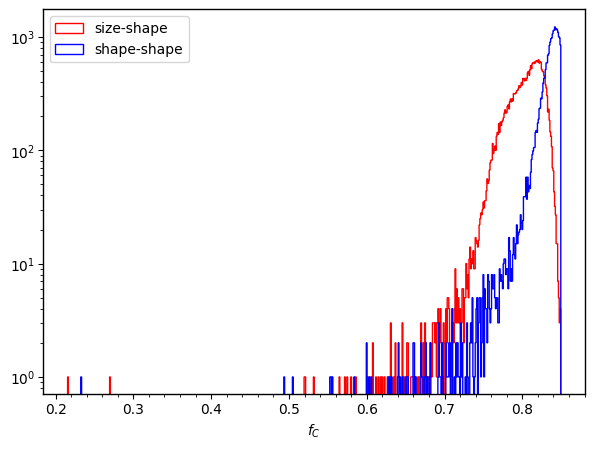

In [24]:

fig,ax = plt.subplots(figsize=(7,5))


ax.hist(idrome_prop_flucs['fC_size_shape'].values,histtype='step',
           bins = np.arange(idrome_prop_flucs['fC_size_shape'].min(),
                           idrome_prop_flucs['fC_size_shape'].max(),0.001),color='red',label='size-shape')
               
ax.hist(idrome_prop_flucs['fC_shape_shape'].values,histtype='step',
           bins = np.arange(idrome_prop_flucs['fC_size_shape'].min(),
                           idrome_prop_flucs['fC_size_shape'].max(),0.001),color='blue',label='shape-shape')

ax.set_xlabel('$f_C$')

ax.legend()
for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1)
ax.set_yscale('log')
ax.minorticks_on()
ax.tick_params(axis='y', which='major', labelsize=10, width = 0.75, pad = 2)
ax.tick_params(axis='y', which='minor', width = 0.6)
ax.tick_params(axis='x', which='major', labelsize=10, width = 0.8, pad = 2)
ax.tick_params(axis='x', which='minor', width = 0.6)


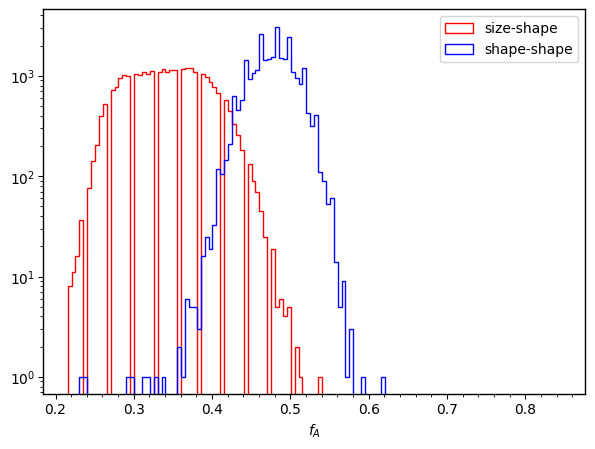

In [25]:

fig,ax = plt.subplots(figsize=(7,5))


ax.hist(idrome_prop_flucs['fA_size_shape'].values,histtype='step',
           bins = np.arange(idrome_prop_flucs['fC_size_shape'].min(),
                           idrome_prop_flucs['fC_size_shape'].max(),0.005),color='red',label='size-shape')
               
ax.hist(idrome_prop_flucs['fA_shape_shape'].values,histtype='step',
           bins = np.arange(idrome_prop_flucs['fC_size_shape'].min(),
                           idrome_prop_flucs['fC_size_shape'].max(),0.005),color='blue',label='shape-shape')

ax.set_xlabel('$f_A$')

ax.legend()
for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1)
ax.set_yscale('log')
ax.minorticks_on()
ax.tick_params(axis='y', which='major', labelsize=10, width = 0.75, pad = 2)
ax.tick_params(axis='y', which='minor', width = 0.6)
ax.tick_params(axis='x', which='major', labelsize=10, width = 0.8, pad = 2)
ax.tick_params(axis='x', which='minor', width = 0.6)


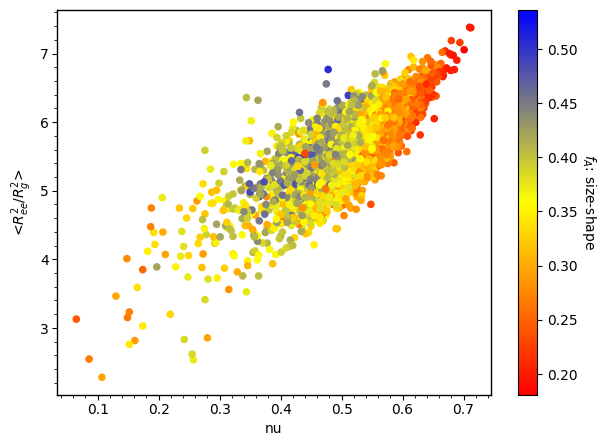

In [43]:
fig,ax = plt.subplots(figsize=(7,5))
palette = matplotlib.colors.LinearSegmentedColormap.from_list("", ['red',"yellow",'blue'])
#palette = plt.get_cmap('viridis')

sc = ax.scatter(idrome_prop_flucs['nu'],
           idrome_prop_flucs['mean_inst_ratio'],s=20,c=idrome_prop_flucs['fA_size_shape'].values,cmap=palette)
               
           
cbar = plt.colorbar(sc)
cbar.set_label('$f_A$: size-shape',rotation=270,labelpad=15)

ax.set_xlabel('nu')
ax.set_ylabel(r'<$R_{ee}^{2}/R_g^{2}$>')

for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1)

ax.minorticks_on()
ax.tick_params(axis='y', which='major', labelsize=10, width = 0.75, pad = 2)
ax.tick_params(axis='y', which='minor', width = 0.6)
ax.tick_params(axis='x', which='major', labelsize=10, width = 0.8, pad = 2)
ax.tick_params(axis='x', which='minor', width = 0.6)

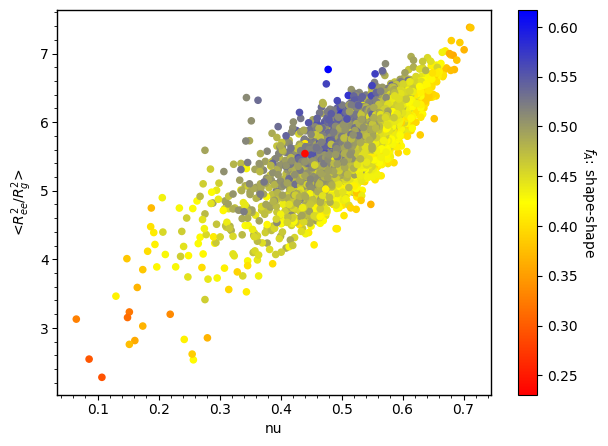

In [42]:
fig,ax = plt.subplots(figsize=(7,5))
palette = matplotlib.colors.LinearSegmentedColormap.from_list("", ['red',"yellow",'blue'])
#palette = plt.get_cmap('viridis')

sc = ax.scatter(idrome_prop_flucs['nu'],
           idrome_prop_flucs['mean_inst_ratio'],s=20,c=idrome_prop_flucs['fA_shape_shape'].values,cmap=palette)
               
           
cbar = plt.colorbar(sc)
cbar.set_label('$f_A$: shape-shape',rotation=270,labelpad=15)

ax.set_xlabel('nu')
ax.set_ylabel(r'<$R_{ee}^{2}/R_g^{2}$>')

for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1)

ax.minorticks_on()
ax.tick_params(axis='y', which='major', labelsize=10, width = 0.75, pad = 2)
ax.tick_params(axis='y', which='minor', width = 0.6)
ax.tick_params(axis='x', which='major', labelsize=10, width = 0.8, pad = 2)
ax.tick_params(axis='x', which='minor', width = 0.6)

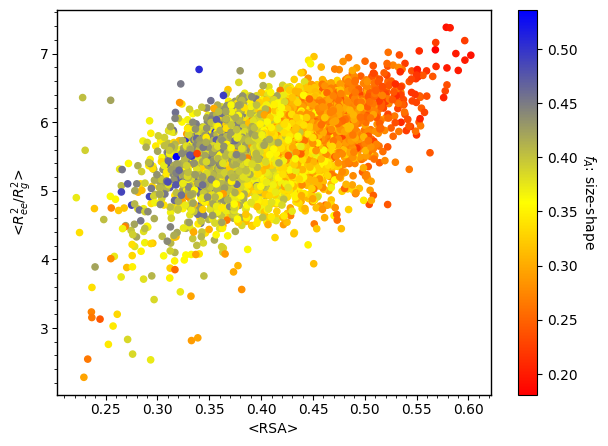

In [39]:
fig,ax = plt.subplots(figsize=(7,5))
palette = matplotlib.colors.LinearSegmentedColormap.from_list("", ['red',"yellow",'blue'])
#palette = plt.get_cmap('viridis')

sc = ax.scatter(idrome_prop_flucs['mean_RSA'],
           idrome_prop_flucs['mean_inst_ratio'],s=20,c=idrome_prop_flucs['fA_size_shape'].values,cmap=palette)
               
           
cbar = plt.colorbar(sc)
cbar.set_label('$f_A$: size-shape',rotation=270,labelpad=15)

ax.set_xlabel('<RSA>')
ax.set_ylabel(r'<$R_{ee}^{2}/R_g^{2}$>')

for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1)

ax.minorticks_on()
ax.tick_params(axis='y', which='major', labelsize=10, width = 0.75, pad = 2)
ax.tick_params(axis='y', which='minor', width = 0.6)
ax.tick_params(axis='x', which='major', labelsize=10, width = 0.8, pad = 2)
ax.tick_params(axis='x', which='minor', width = 0.6)

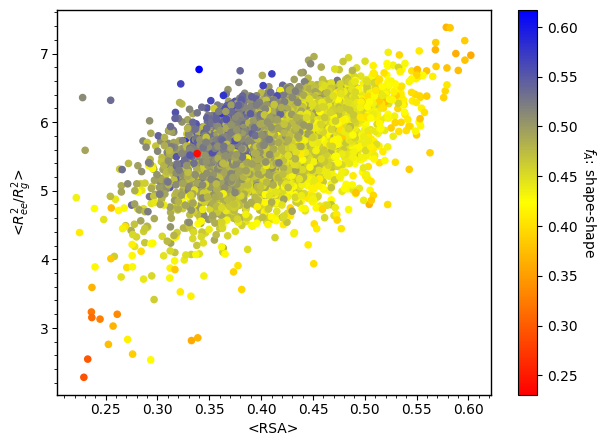

In [44]:
fig,ax = plt.subplots(figsize=(7,5))
palette = matplotlib.colors.LinearSegmentedColormap.from_list("", ['red',"yellow",'blue'])
#palette = plt.get_cmap('viridis')

sc = ax.scatter(idrome_prop_flucs['mean_RSA'],
           idrome_prop_flucs['mean_inst_ratio'],s=20,c=idrome_prop_flucs['fA_shape_shape'].values,cmap=palette)
               
           
cbar = plt.colorbar(sc)
cbar.set_label('$f_A$: shape-shape',rotation=270,labelpad=15)

ax.set_xlabel('<RSA>')
ax.set_ylabel(r'<$R_{ee}^{2}/R_g^{2}$>')

for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1)

ax.minorticks_on()
ax.tick_params(axis='y', which='major', labelsize=10, width = 0.75, pad = 2)
ax.tick_params(axis='y', which='minor', width = 0.6)
ax.tick_params(axis='x', which='major', labelsize=10, width = 0.8, pad = 2)
ax.tick_params(axis='x', which='minor', width = 0.6)

# fC 

In [15]:
#drop these IDR simulations because of low snapshots #
seq_name_dir_df[seq_name_dir_df.seq_name.isin(['Q53SF7_218_1128',
                                             'Q7Z2Y5_341_1224'
                                             'IDROME_larsen/IDRome_v4/Q9/Y2/W1/1_611',
                                             'IDROME_larsen/IDRome_v4/Q9/BX/T5/1_968'])]

,seq_name,seq_dir,protein_uniprot_id
3703,Q53SF7_218_1128,IDROME_larsen/IDRome_v4/Q5/3S/F7/218_1128,Q53SF7
27365,Q9BXT5_1_968,IDROME_larsen/IDRome_v4/Q9/BX/T5/1_968,Q9BXT5


In [ ]:
%%time
for seq_dir in seq_name_dir_df.seq_dir.values:
    if np.load(seq_dir+'/rg.npy').shape[0]!=1000:
        print(seq_name_dir_df[seq_name_dir_df.seq_dir==seq_dir].seq_name, np.load(seq_dir+'/rg.npy').shape[0])

3703    Q53SF7_218_1128
Name: seq_name, dtype: object 500
11700    Q7Z2Y5_341_1224
Name: seq_name, dtype: object 420


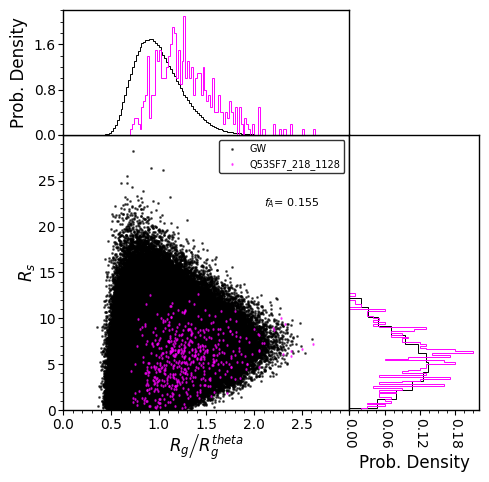

In [107]:
compute_3dplot_from_seq_name('Q53SF7_218_1128')

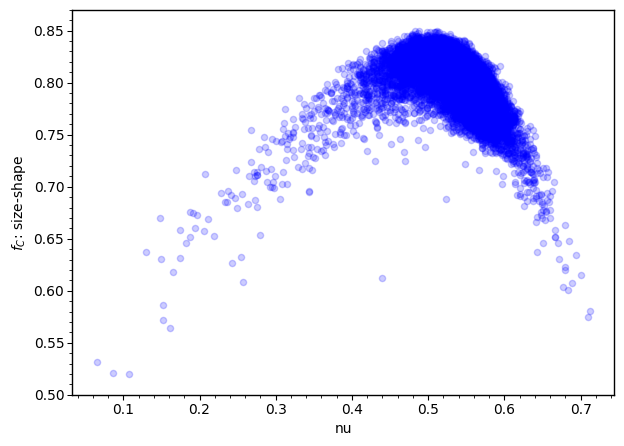

In [16]:
fig,ax = plt.subplots(figsize=(7,5))
palette = matplotlib.colors.LinearSegmentedColormap.from_list("", ['red',"yellow",'blue'])
#palette = plt.get_cmap('viridis')

sc = ax.scatter(idrome_prop_flucs['nu'],idrome_prop_flucs['fC_size_shape'],s=20,alpha=0.2,
                color='blue')
               
ax.set_xlabel('nu')
ax.set_ylabel('$f_C$: size-shape')
ax.set_ylim(0.5,0.87)
for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1)

ax.minorticks_on()
ax.tick_params(axis='y', which='major', labelsize=10, width = 0.75, pad = 2)
ax.tick_params(axis='y', which='minor', width = 0.6)
ax.tick_params(axis='x', which='major', labelsize=10, width = 0.8, pad = 2)
ax.tick_params(axis='x', which='minor', width = 0.6)

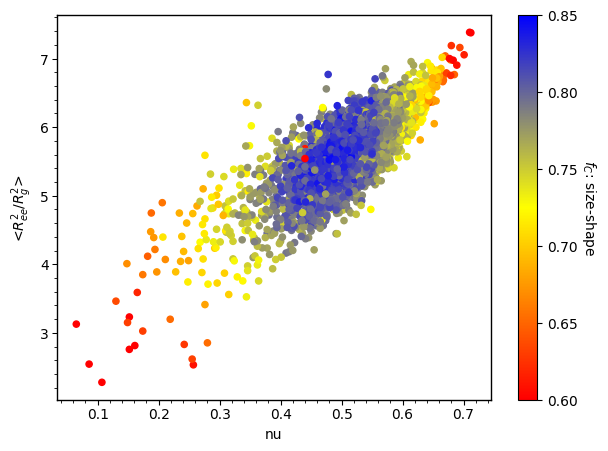

In [14]:
fig,ax = plt.subplots(figsize=(7,5))
palette = matplotlib.colors.LinearSegmentedColormap.from_list("", ['red',"yellow",'blue'])
#palette = plt.get_cmap('viridis')

sc = ax.scatter(idrome_prop_flucs['nu'],
           idrome_prop_flucs['mean_inst_ratio'],s=20,
                c=idrome_prop_flucs['fC_size_shape'].values,cmap=palette,vmin=0.6,vmax=0.85)
               
cbar = plt.colorbar(sc)
cbar.set_label('$f_C$: size-shape',rotation=270,labelpad=15)

ax.set_xlabel('nu')
ax.set_ylabel(r'<$R_{ee}^{2}/R_g^{2}$>')

for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1)

ax.minorticks_on()
ax.tick_params(axis='y', which='major', labelsize=10, width = 0.75, pad = 2)
ax.tick_params(axis='y', which='minor', width = 0.6)
ax.tick_params(axis='x', which='major', labelsize=10, width = 0.8, pad = 2)
ax.tick_params(axis='x', which='minor', width = 0.6)

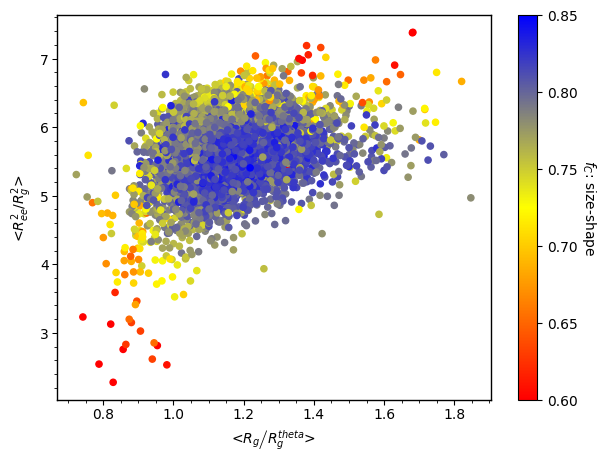

In [15]:
fig,ax = plt.subplots(figsize=(7,5))
palette = matplotlib.colors.LinearSegmentedColormap.from_list("", ['red',"yellow",'blue'])
#palette = plt.get_cmap('viridis')

sc = ax.scatter(idrome_prop_flucs['rg_rg_theta_mean'],
           idrome_prop_flucs['mean_inst_ratio'],s=20,c=idrome_prop_flucs['fC_size_shape'].values,cmap=palette,vmin=0.6,vmax=0.85)
               
           
cbar = plt.colorbar(sc)
cbar.set_label('$f_C$: size-shape',rotation=270,labelpad=15)

ax.set_xlabel(r'<$R_g\left/R_g^{theta}\right.$>')
ax.set_ylabel(r'<$R_{ee}^{2}/R_g^{2}$>')

for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1)

ax.minorticks_on()
ax.tick_params(axis='y', which='major', labelsize=10, width = 0.75, pad = 2)
ax.tick_params(axis='y', which='minor', width = 0.6)
ax.tick_params(axis='x', which='major', labelsize=10, width = 0.8, pad = 2)
ax.tick_params(axis='x', which='minor', width = 0.6)

# <Rg/Rg_theta> and shape and fA do not seem to have a trend

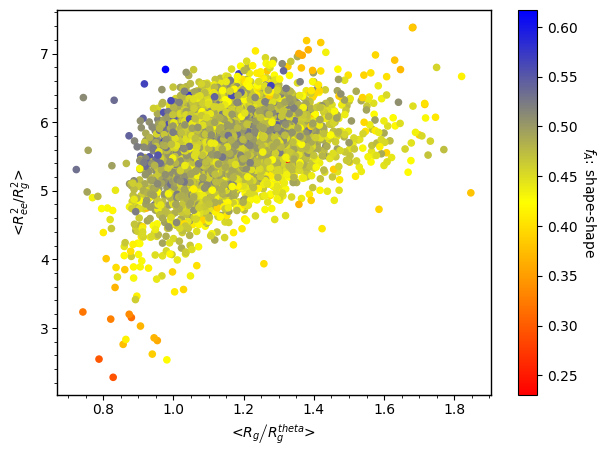

In [41]:
fig,ax = plt.subplots(figsize=(7,5))
palette = matplotlib.colors.LinearSegmentedColormap.from_list("", ['red',"yellow",'blue'])
#palette = plt.get_cmap('viridis')

sc = ax.scatter(idrome_prop_flucs['rg_rg_theta_mean'],
           idrome_prop_flucs['mean_inst_ratio'],s=20,c=idrome_prop_flucs['fA_shape_shape'].values,cmap=palette)
               
           
cbar = plt.colorbar(sc)
cbar.set_label('$f_A$: shape-shape',rotation=270,labelpad=15)

ax.set_xlabel(r'<$R_g\left/R_g^{theta}\right.$>')
ax.set_ylabel(r'<$R_{ee}^{2}/R_g^{2}$>')

for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1)

ax.minorticks_on()
ax.tick_params(axis='y', which='major', labelsize=10, width = 0.75, pad = 2)
ax.tick_params(axis='y', which='minor', width = 0.6)
ax.tick_params(axis='x', which='major', labelsize=10, width = 0.8, pad = 2)
ax.tick_params(axis='x', which='minor', width = 0.6)

# lets see if predict nu from fluctuations

In [59]:
X = idrome_prop_flucs[idrome_prop_flucs.columns[(idrome_prop_flucs.columns.str.contains('fA'))|(idrome_prop_flucs.columns.str.contains('fC'))]]
y = idrome_prop_flucs['nu']

## random forest regressor
## using 25% test data-set

In [60]:
# adapted from this website: https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

labels = np.array(y)
features= np.array(X)

In [61]:

print('fixed seed here')
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

fixed seed here


In [62]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (21043, 4)
Training Labels Shape: (21043,)
Testing Features Shape: (7015, 4)
Testing Labels Shape: (7015,)


In [63]:
%%time
from sklearn.ensemble import RandomForestRegressor
chosen_model=RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf = chosen_model

rf.fit(train_features, train_labels);

CPU times: user 1min 4s, sys: 96.7 ms, total: 1min 4s
Wall time: 1min 4s


In [64]:
predictions = rf.predict(test_features)
# Calculate the errors
errors = predictions - test_labels
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(abs(errors)), 2))
print('MSE:', round(mean_squared_error(test_labels,predictions),2))

Mean Absolute Error: 0.02
MSE: 0.0


## predicted vs actual values for test dataset

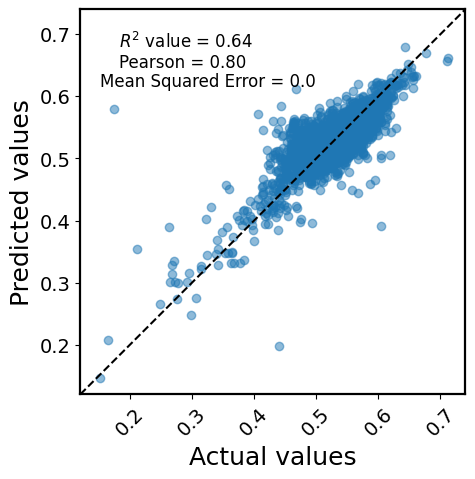

In [65]:
fig, ax = plt.subplots(figsize=(6,5))

true_val,pred_val = test_labels,predictions
ax.scatter(true_val,pred_val,alpha=0.5)



lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

ax.text(0.1,
                   0.9,f'$R^2$ value = {format(r2_score(true_val,pred_val),"0.2f")}',
                   transform=ax.transAxes,fontsize=12)

ax.text(0.1,
                   0.85,f'Pearson = {format(pearsonr(true_val, pred_val)[0],"0.2f")}',
                   transform=ax.transAxes,fontsize=12)
ax.text(0.05,
                   0.8,f'Mean Squared Error = {round(mean_squared_error(true_val,pred_val),2)}',
                   transform=ax.transAxes,fontsize=12)


# now plot both limits against eachother
ax.plot(lims, lims, 'k--', alpha=1, zorder=1)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

plt.setp(ax.get_xticklabels(),fontsize=14,rotation=45)
plt.setp(ax.get_yticklabels(),fontsize=14)
ax.set_xlabel('Actual values',fontsize=18)
ax.set_ylabel('Predicted values',fontsize=18)

for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)
del true_val, pred_val

## double-check what predicted vs actual looks like for training dataset

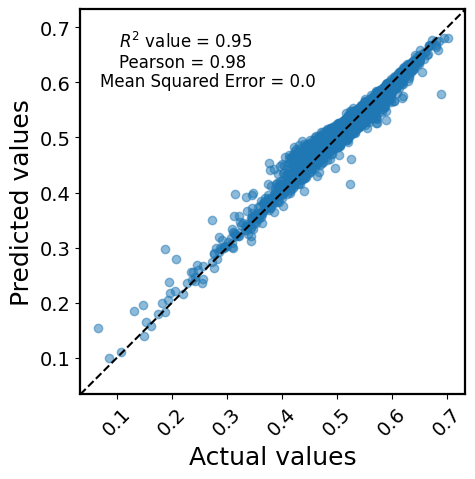

In [66]:
fig, ax = plt.subplots(figsize=(6,5))

true_val,pred_val = train_labels,rf.predict(train_features)
ax.scatter(true_val,pred_val,alpha=0.5)



lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

ax.text(0.1,
                   0.9,f'$R^2$ value = {format(r2_score(true_val,pred_val),"0.2f")}',
                   transform=ax.transAxes,fontsize=12)

ax.text(0.1,
                   0.85,f'Pearson = {format(pearsonr(true_val,pred_val)[0],"0.2f")}',
                   transform=ax.transAxes,fontsize=12)
ax.text(0.05,
                   0.8,f'Mean Squared Error = {round(mean_squared_error(true_val,pred_val),2)}',
                   transform=ax.transAxes,fontsize=12)


# now plot both limits against eachother
ax.plot(lims, lims, 'k--', alpha=1, zorder=1)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

plt.setp(ax.get_xticklabels(),fontsize=14,rotation=45)
plt.setp(ax.get_yticklabels(),fontsize=14)
ax.set_xlabel('Actual values',fontsize=18)
ax.set_ylabel('Predicted values',fontsize=18)

for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)
del true_val, pred_val

## Residuals (only for test dataset)

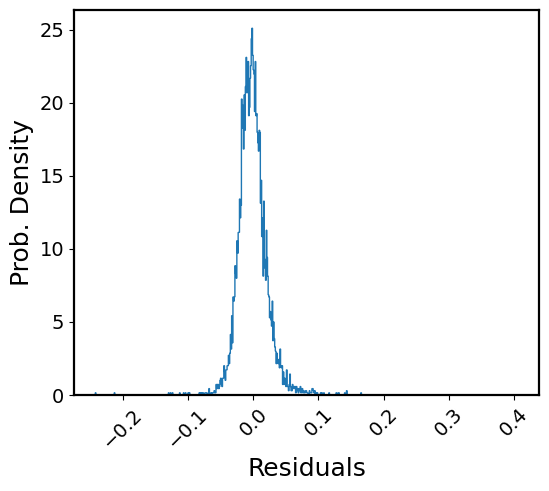

In [67]:
fig, ax = plt.subplots(figsize=(6,5))
ax.hist(errors,bins=np.arange(np.min(errors),np.max(errors),0.001),histtype='step',density=True,linewidth=1)
plt.setp(ax.get_xticklabels(),fontsize=14,rotation=45)
plt.setp(ax.get_yticklabels(),fontsize=14)
ax.set_xlabel('Residuals',fontsize=18)
ax.set_ylabel('Prob. Density',fontsize=18)

for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)

In [68]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (abs(errors) / test_labels)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 96.92 %.


In [69]:
del labels, features, mape, accuracy, predictions, errors,train_features, test_features, train_labels, test_labels, rf

## Now running model 6 times each time using random train-test split

CPU times: user 6min 33s, sys: 1.55 s, total: 6min 34s
Wall time: 6min 35s


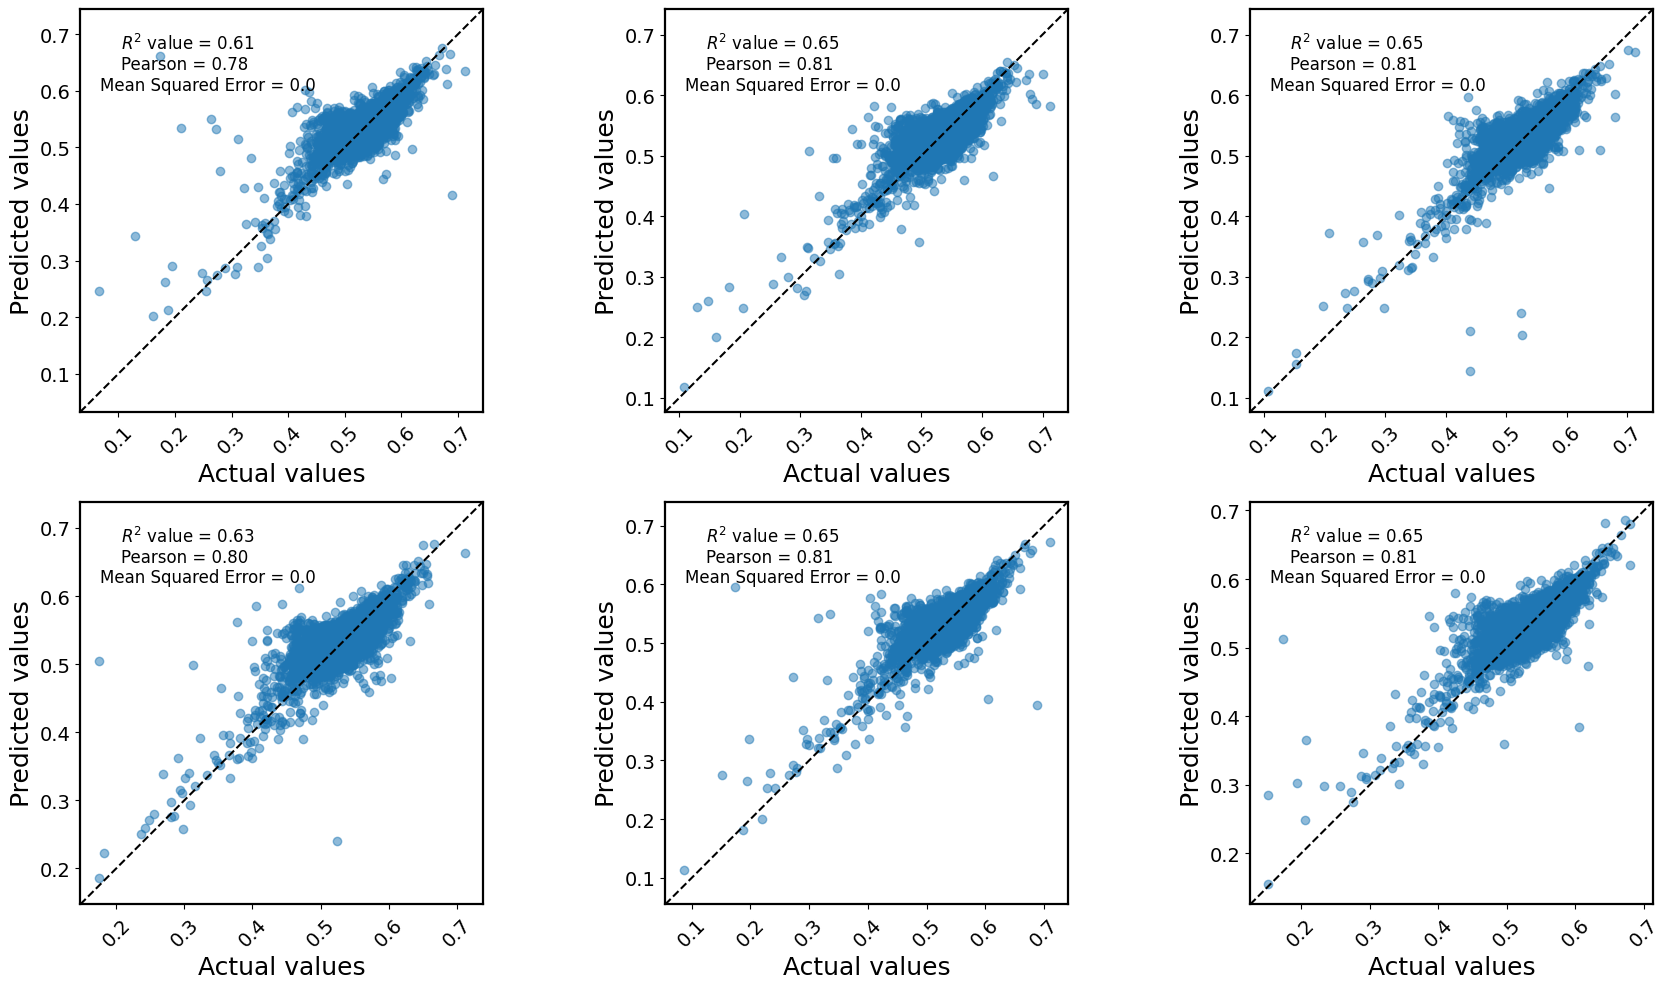

In [70]:
%%time
fig, axs = plt.subplots(nrows=2,ncols=3,figsize=(18,10))
n = 6
for i,ax in zip(range(n),axs.ravel()):
    features= np.array(X)
    labels = np.array(y)
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = i)    
    rf = chosen_model
    rf.fit(train_features, train_labels);
    predictions = rf.predict(test_features)
    errors = predictions - test_labels
    
    #Generate plot
    
    true_val,pred_val = test_labels,predictions
    ax.scatter(true_val,pred_val,alpha=0.5)
    
    
    
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    
    ax.text(0.1,
                       0.9,f'$R^2$ value = {format(r2_score(true_val,pred_val),"0.2f")}',
                       transform=ax.transAxes,fontsize=12)
    
    ax.text(0.1,
                       0.85,f'Pearson = {format(pearsonr(true_val,pred_val)[0],"0.2f")}',
                       transform=ax.transAxes,fontsize=12)
    ax.text(0.05,
                       0.8,f'Mean Squared Error = {round(mean_squared_error(true_val,pred_val),2)}',
                       transform=ax.transAxes,fontsize=12)
    
    
    # now plot both limits against eachother
    ax.plot(lims, lims, 'k--', alpha=1, zorder=1)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    
    plt.setp(ax.get_xticklabels(),fontsize=14,rotation=45)
    plt.setp(ax.get_yticklabels(),fontsize=14)
    ax.set_xlabel('Actual values',fontsize=18)
    ax.set_ylabel('Predicted values',fontsize=18)
    
    for i in ['top', 'left', 'right', 'bottom']:
            ax.spines[i].set_linewidth(1.6)
    del true_val, pred_val

plt.tight_layout()

In [71]:
del chosen_model, labels, features, train_features, test_features, train_labels, test_labels, rf, predictions, errors

# lets see if predict mean_inst_ratio from fluctuations

In [35]:
X = idrome_prop_flucs[idrome_prop_flucs.columns[(idrome_prop_flucs.columns.str.contains('fA'))|(idrome_prop_flucs.columns.str.contains('fC'))]]
y = idrome_prop_flucs['mean_inst_ratio']

## random forest regressor
## using 25% test data-set

In [36]:
# adapted from this website: https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

labels = np.array(y)
features= np.array(X)

In [37]:

print('fixed seed here')
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

fixed seed here


In [38]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (21043, 4)
Training Labels Shape: (21043,)
Testing Features Shape: (7015, 4)
Testing Labels Shape: (7015,)


In [39]:
from sklearn.ensemble import RandomForestRegressor
chosen_model=RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf = chosen_model

rf.fit(train_features, train_labels);

In [40]:
predictions = rf.predict(test_features)
# Calculate the errors
errors = predictions - test_labels
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(abs(errors)), 2))
print('MSE:', round(mean_squared_error(test_labels,predictions),2))

Mean Absolute Error: 0.17
MSE: 0.05


## predicted vs actual values for test dataset

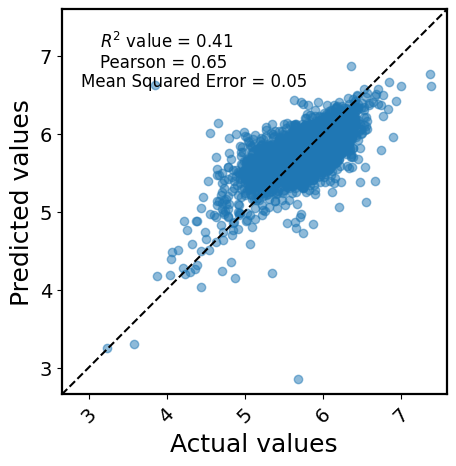

In [41]:
fig, ax = plt.subplots(figsize=(6,5))

true_val,pred_val = test_labels,predictions
ax.scatter(true_val,pred_val,alpha=0.5)



lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

ax.text(0.1,
                   0.9,f'$R^2$ value = {format(r2_score(true_val,pred_val),"0.2f")}',
                   transform=ax.transAxes,fontsize=12)

ax.text(0.1,
                   0.85,f'Pearson = {format(pearsonr(true_val, pred_val)[0],"0.2f")}',
                   transform=ax.transAxes,fontsize=12)
ax.text(0.05,
                   0.8,f'Mean Squared Error = {round(mean_squared_error(true_val,pred_val),2)}',
                   transform=ax.transAxes,fontsize=12)


# now plot both limits against eachother
ax.plot(lims, lims, 'k--', alpha=1, zorder=1)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

plt.setp(ax.get_xticklabels(),fontsize=14,rotation=45)
plt.setp(ax.get_yticklabels(),fontsize=14)
ax.set_xlabel('Actual values',fontsize=18)
ax.set_ylabel('Predicted values',fontsize=18)

for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)
del true_val, pred_val

## double-check what predicted vs actual looks like for training dataset

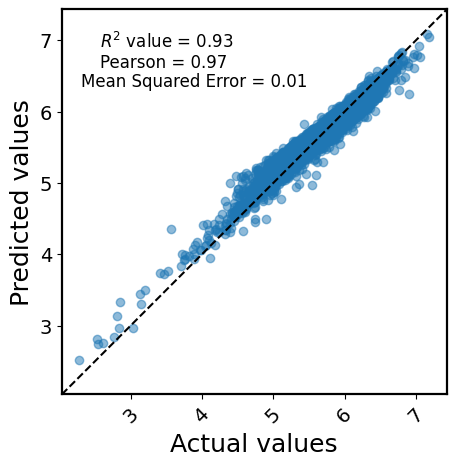

In [42]:
fig, ax = plt.subplots(figsize=(6,5))

true_val,pred_val = train_labels,rf.predict(train_features)
ax.scatter(true_val,pred_val,alpha=0.5)



lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

ax.text(0.1,
                   0.9,f'$R^2$ value = {format(r2_score(true_val,pred_val),"0.2f")}',
                   transform=ax.transAxes,fontsize=12)

ax.text(0.1,
                   0.85,f'Pearson = {format(pearsonr(true_val,pred_val)[0],"0.2f")}',
                   transform=ax.transAxes,fontsize=12)
ax.text(0.05,
                   0.8,f'Mean Squared Error = {round(mean_squared_error(true_val,pred_val),2)}',
                   transform=ax.transAxes,fontsize=12)


# now plot both limits against eachother
ax.plot(lims, lims, 'k--', alpha=1, zorder=1)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

plt.setp(ax.get_xticklabels(),fontsize=14,rotation=45)
plt.setp(ax.get_yticklabels(),fontsize=14)
ax.set_xlabel('Actual values',fontsize=18)
ax.set_ylabel('Predicted values',fontsize=18)

for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)
del true_val, pred_val

## Residuals (only for test dataset)

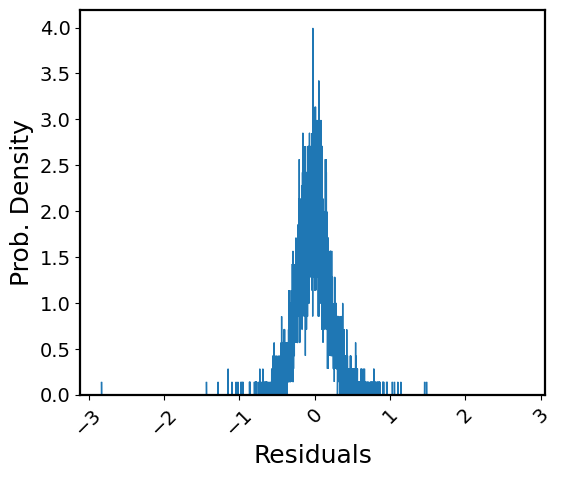

In [43]:
fig, ax = plt.subplots(figsize=(6,5))
ax.hist(errors,bins=np.arange(np.min(errors),np.max(errors),0.001),histtype='step',density=True,linewidth=1)
plt.setp(ax.get_xticklabels(),fontsize=14,rotation=45)
plt.setp(ax.get_yticklabels(),fontsize=14)
ax.set_xlabel('Residuals',fontsize=18)
ax.set_ylabel('Prob. Density',fontsize=18)

for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)

In [44]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (abs(errors) / test_labels)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 97.05 %.


In [45]:
del labels, features, mape, accuracy, predictions, errors,train_features, test_features, train_labels, test_labels, rf

## Now running model 6 times each time using random train-test split

In [ ]:
%%time
fig, axs = plt.subplots(nrows=2,ncols=3,figsize=(18,10))
n = 6
for i,ax in zip(range(n),axs.ravel()):
    features= np.array(X)
    labels = np.array(y)
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = i)    
    rf = chosen_model
    rf.fit(train_features, train_labels);
    predictions = rf.predict(test_features)
    errors = predictions - test_labels
    
    #Generate plot
    
    true_val,pred_val = test_labels,predictions
    ax.scatter(true_val,pred_val,alpha=0.5)
    
    
    
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    
    ax.text(0.1,
                       0.9,f'$R^2$ value = {format(r2_score(true_val,pred_val),"0.2f")}',
                       transform=ax.transAxes,fontsize=12)
    
    ax.text(0.1,
                       0.85,f'Pearson = {format(pearsonr(true_val,pred_val)[0],"0.2f")}',
                       transform=ax.transAxes,fontsize=12)
    ax.text(0.05,
                       0.8,f'Mean Squared Error = {round(mean_squared_error(true_val,pred_val),2)}',
                       transform=ax.transAxes,fontsize=12)
    
    
    # now plot both limits against eachother
    ax.plot(lims, lims, 'k--', alpha=1, zorder=1)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    
    plt.setp(ax.get_xticklabels(),fontsize=14,rotation=45)
    plt.setp(ax.get_yticklabels(),fontsize=14)
    ax.set_xlabel('Actual values',fontsize=18)
    ax.set_ylabel('Predicted values',fontsize=18)
    
    for i in ['top', 'left', 'right', 'bottom']:
            ax.spines[i].set_linewidth(1.6)
    del true_val, pred_val

plt.tight_layout()

In [ ]:
del chosen_model, labels, features, train_features, test_features, train_labels, test_labels, rf, predictions, errors

# lets see if predict mean_RSA from fluctuations

In [46]:
X = idrome_prop_flucs[idrome_prop_flucs.columns[(idrome_prop_flucs.columns.str.contains('fA'))|(idrome_prop_flucs.columns.str.contains('fC'))]]
y = idrome_prop_flucs['mean_RSA']

## random forest regressor
## using 25% test data-set

In [47]:
# adapted from this website: https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

labels = np.array(y)
features= np.array(X)

In [48]:

print('fixed seed here')
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

fixed seed here


In [49]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (21043, 4)
Training Labels Shape: (21043,)
Testing Features Shape: (7015, 4)
Testing Labels Shape: (7015,)


In [50]:
from sklearn.ensemble import RandomForestRegressor
chosen_model=RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf = chosen_model

rf.fit(train_features, train_labels);

In [51]:
predictions = rf.predict(test_features)
# Calculate the errors
errors = predictions - test_labels
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(abs(errors)), 2))
print('MSE:', round(mean_squared_error(test_labels,predictions),2))

Mean Absolute Error: 0.01
MSE: 0.0


## predicted vs actual values for test dataset

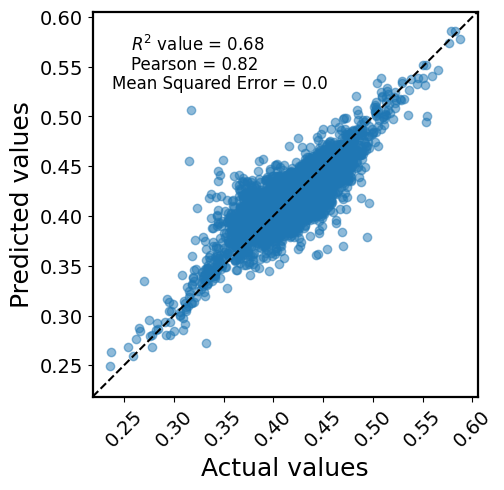

In [52]:
fig, ax = plt.subplots(figsize=(6,5))

true_val,pred_val = test_labels,predictions
ax.scatter(true_val,pred_val,alpha=0.5)



lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

ax.text(0.1,
                   0.9,f'$R^2$ value = {format(r2_score(true_val,pred_val),"0.2f")}',
                   transform=ax.transAxes,fontsize=12)

ax.text(0.1,
                   0.85,f'Pearson = {format(pearsonr(true_val, pred_val)[0],"0.2f")}',
                   transform=ax.transAxes,fontsize=12)
ax.text(0.05,
                   0.8,f'Mean Squared Error = {round(mean_squared_error(true_val,pred_val),2)}',
                   transform=ax.transAxes,fontsize=12)


# now plot both limits against eachother
ax.plot(lims, lims, 'k--', alpha=1, zorder=1)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

plt.setp(ax.get_xticklabels(),fontsize=14,rotation=45)
plt.setp(ax.get_yticklabels(),fontsize=14)
ax.set_xlabel('Actual values',fontsize=18)
ax.set_ylabel('Predicted values',fontsize=18)

for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)
del true_val, pred_val

## double-check what predicted vs actual looks like for training dataset

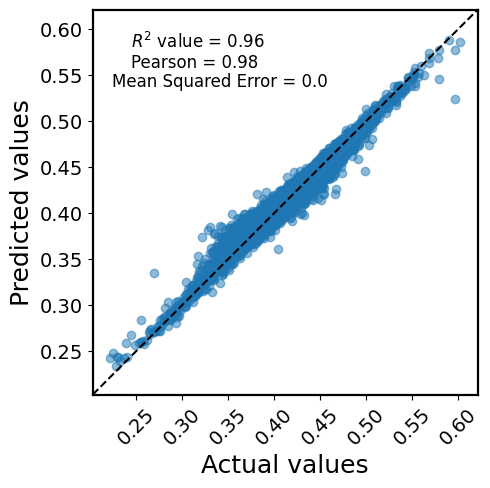

In [53]:
fig, ax = plt.subplots(figsize=(6,5))

true_val,pred_val = train_labels,rf.predict(train_features)
ax.scatter(true_val,pred_val,alpha=0.5)



lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

ax.text(0.1,
                   0.9,f'$R^2$ value = {format(r2_score(true_val,pred_val),"0.2f")}',
                   transform=ax.transAxes,fontsize=12)

ax.text(0.1,
                   0.85,f'Pearson = {format(pearsonr(true_val,pred_val)[0],"0.2f")}',
                   transform=ax.transAxes,fontsize=12)
ax.text(0.05,
                   0.8,f'Mean Squared Error = {round(mean_squared_error(true_val,pred_val),2)}',
                   transform=ax.transAxes,fontsize=12)


# now plot both limits against eachother
ax.plot(lims, lims, 'k--', alpha=1, zorder=1)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

plt.setp(ax.get_xticklabels(),fontsize=14,rotation=45)
plt.setp(ax.get_yticklabels(),fontsize=14)
ax.set_xlabel('Actual values',fontsize=18)
ax.set_ylabel('Predicted values',fontsize=18)

for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)
del true_val, pred_val

## Residuals (only for test dataset)

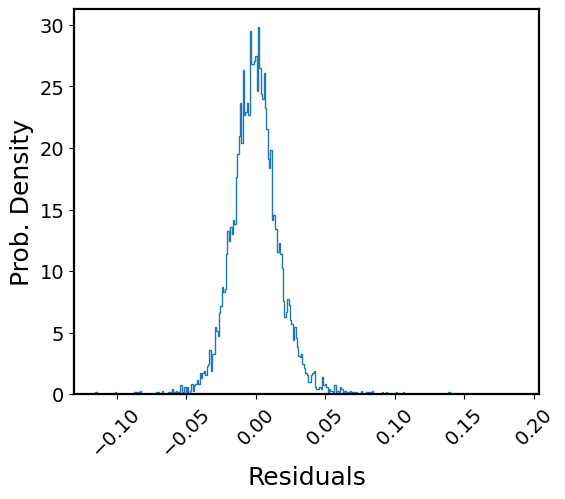

In [54]:
fig, ax = plt.subplots(figsize=(6,5))
ax.hist(errors,bins=np.arange(np.min(errors),np.max(errors),0.001),histtype='step',density=True,linewidth=1)
plt.setp(ax.get_xticklabels(),fontsize=14,rotation=45)
plt.setp(ax.get_yticklabels(),fontsize=14)
ax.set_xlabel('Residuals',fontsize=18)
ax.set_ylabel('Prob. Density',fontsize=18)

for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)

In [55]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (abs(errors) / test_labels)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 96.86 %.


In [56]:
del labels, features, mape, accuracy, predictions, errors,train_features, test_features, train_labels, test_labels, rf

## Now running model 6 times each time using random train-test split

CPU times: user 6min 32s, sys: 1.82 s, total: 6min 34s
Wall time: 6min 34s


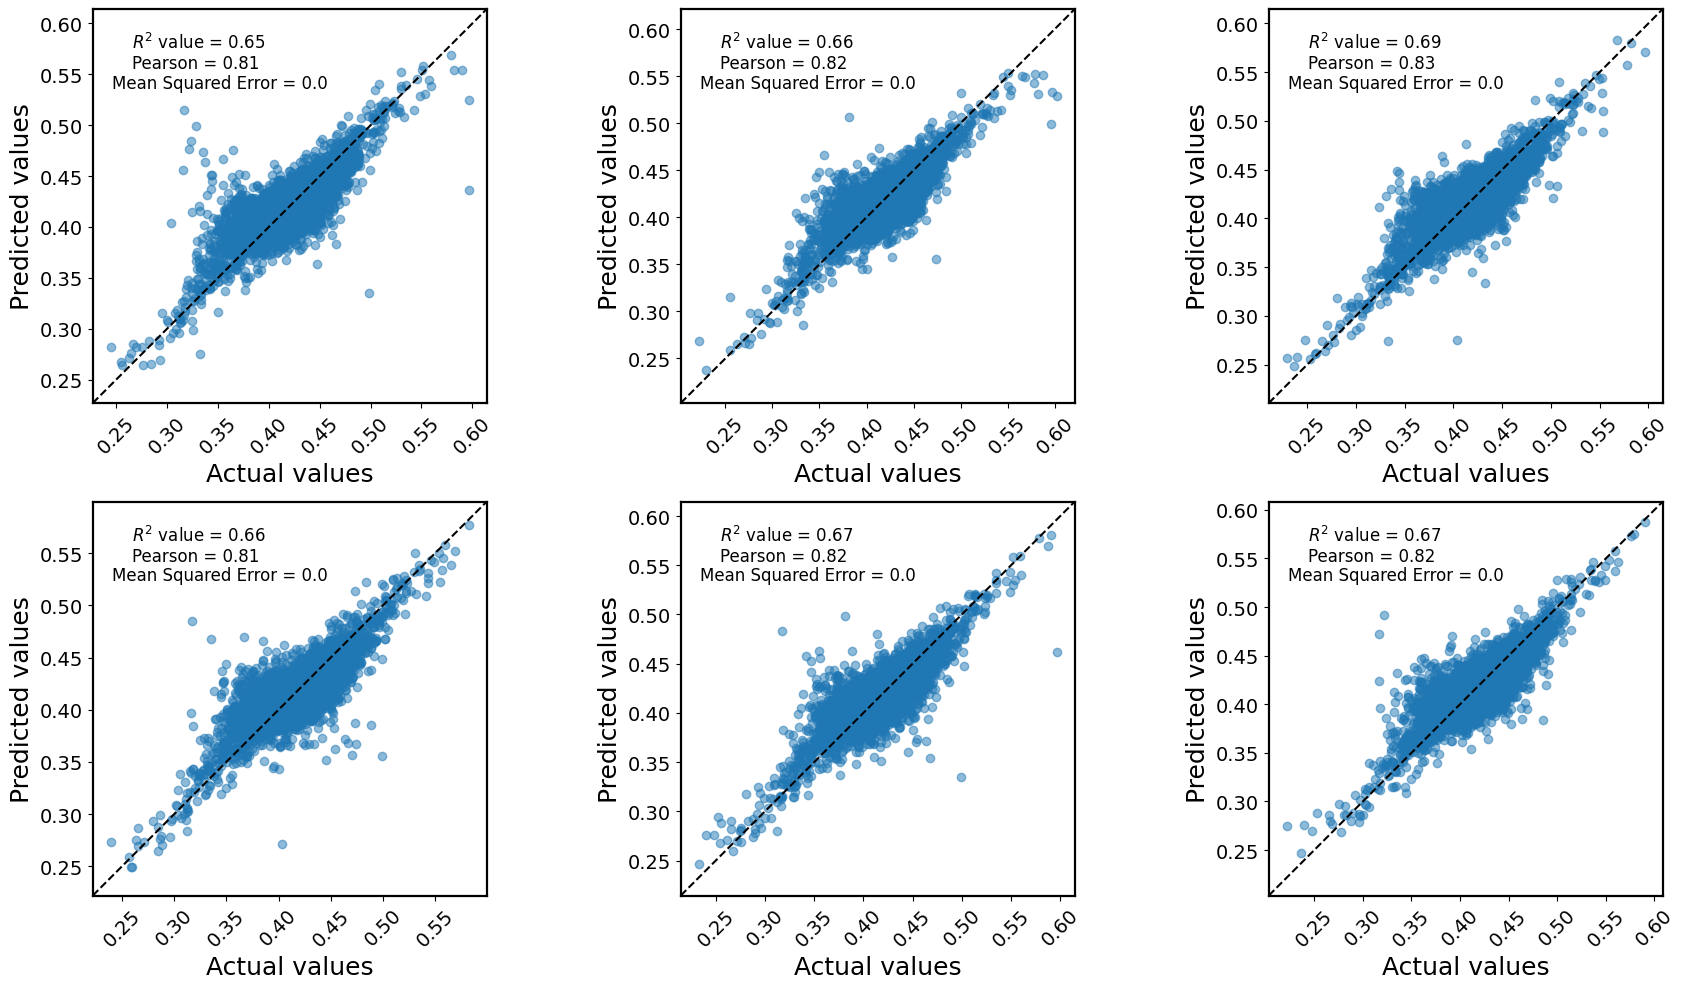

In [57]:
%%time
fig, axs = plt.subplots(nrows=2,ncols=3,figsize=(18,10))
n = 6
for i,ax in zip(range(n),axs.ravel()):
    features= np.array(X)
    labels = np.array(y)
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = i)    
    rf = chosen_model
    rf.fit(train_features, train_labels);
    predictions = rf.predict(test_features)
    errors = predictions - test_labels
    
    #Generate plot
    
    true_val,pred_val = test_labels,predictions
    ax.scatter(true_val,pred_val,alpha=0.5)
    
    
    
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    
    ax.text(0.1,
                       0.9,f'$R^2$ value = {format(r2_score(true_val,pred_val),"0.2f")}',
                       transform=ax.transAxes,fontsize=12)
    
    ax.text(0.1,
                       0.85,f'Pearson = {format(pearsonr(true_val,pred_val)[0],"0.2f")}',
                       transform=ax.transAxes,fontsize=12)
    ax.text(0.05,
                       0.8,f'Mean Squared Error = {round(mean_squared_error(true_val,pred_val),2)}',
                       transform=ax.transAxes,fontsize=12)
    
    
    # now plot both limits against eachother
    ax.plot(lims, lims, 'k--', alpha=1, zorder=1)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    
    plt.setp(ax.get_xticklabels(),fontsize=14,rotation=45)
    plt.setp(ax.get_yticklabels(),fontsize=14)
    ax.set_xlabel('Actual values',fontsize=18)
    ax.set_ylabel('Predicted values',fontsize=18)
    
    for i in ['top', 'left', 'right', 'bottom']:
            ax.spines[i].set_linewidth(1.6)
    del true_val, pred_val

plt.tight_layout()

In [58]:
del chosen_model, labels, features, train_features, test_features, train_labels, test_labels, rf, predictions, errors